Imports

In [10]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Loading dataset

In [11]:
concrete_compressive_strength = fetch_ucirepo(id = 165)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets
df = pd.concat([X,y],axis=1)
# Adding a column of ones as intercept
X = np.hstack((np.ones((X.shape[0], 1)), X.values))
y = y.to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.dtype)

float64


Defining prior (The prior mean is set to zero and the prior covariance matrix is set to 1000 which means a weak prior)

In [12]:
def define_prior(dim):
    prior_mean = np.zeros(dim)
    prior_cov = np.eye(dim)*1000
    return prior_mean,prior_cov

Defining Probability Function (Gaussian Likelihood with known variancw `sigma_sq`)

In [13]:
def probability(X,y,w,sigma_sq):
    n = len(y)
    y_pred = X @ w
    residual = y-y_pred
    return (1/np.sqrt(2*np.pi*sigma_sq))**n*np.exp(-0.5*np.sum(residual**2)/sigma_sq)

Defining Posterior

In [14]:
def posterior(X, y, prior_mean, prior_cov, sigma_sq):
    precision_prior = np.linalg.inv(prior_cov)
    precision_likelihood = X.T @ X / sigma_sq
    precision_posterior = precision_prior + precision_likelihood
    cov_posterior = np.linalg.inv(precision_posterior)    
    mean_posterior = cov_posterior @ (precision_prior @ prior_mean + X.T @ y / sigma_sq)
    return mean_posterior, cov_posterior


Initializing prior and computer posteriors: 

In [15]:
dim = X.shape[1]
prior_mean,prior_cov = define_prior(dim)
sigma_sq = 1 # This is known noise variance (I assumed it to be 1)
post_mean, post_cov = posterior(X,y,prior_mean,prior_cov,sigma_sq)
#post_mean = post_mean.flatten()
post_mean = post_mean
print(post_mean.shape)
print(post_cov.shape)

(9, 9)
(9, 9)


Sampling from the posterior:

In [43]:
n_samples = 100
print(post_mean[:,2])
samples = np.random.multivariate_normal(post_mean[:,2], post_cov, n_samples)

[ 0.         12.51405363  8.95694408  5.6246418  -3.1999591   1.74485751
  1.4054678   1.61783502  7.2118791 ]


Predictions: 

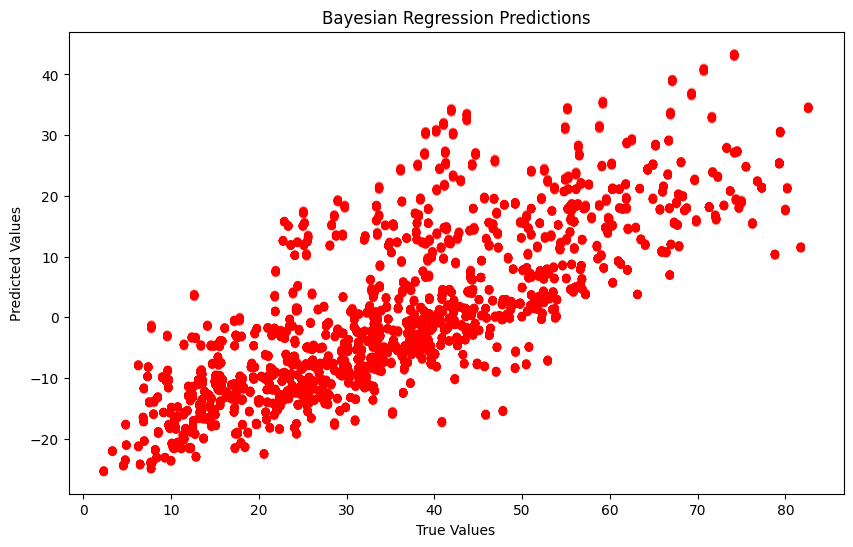

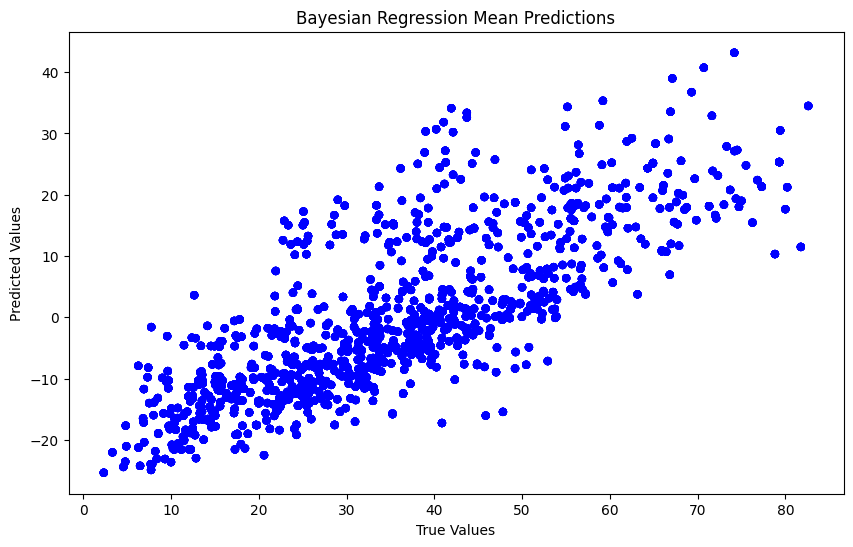

In [45]:
y_preds = X @ samples.T
y_pred_mean = X @ post_mean
plt.figure(figsize=(10, 6))
for i in range(n_samples):
    plt.scatter(y, y_preds[:, i], color='red', alpha=0.1, edgecolor='none')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Bayesian Regression Predictions')
plt.show()
plt.figure(figsize=(10, 6))
for i in range(0,9):
    plt.scatter(y, y_pred_mean[:,i], color='blue', edgecolor='none')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Bayesian Regression Mean Predictions')
plt.show()

Just compare the plots above